## EG Technical Assesment
- We will start by importing necessary libraries and doing some EDA

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



c:\Users\Barre\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Barre\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Barre\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Barre\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv(r"C:\Users\Barre\Downloads\starcraft_player_data.csv")


## Exploratory data analysis

I am going to go ahead and drop duplicate values if there are any as well as the GameID column because it is only used as an index


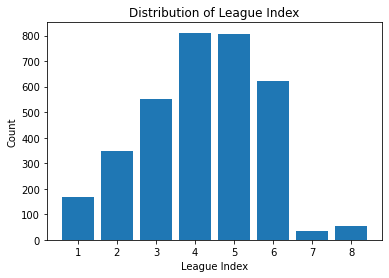

In [3]:
league_counts = df['LeagueIndex'].value_counts()

league_counts = league_counts.sort_index()

plt.bar(league_counts.index, league_counts.values)

plt.xlabel('League Index')
plt.ylabel('Count')
plt.title('Distribution of League Index')

plt.show()

In [4]:
df.drop_duplicates()
df.drop(columns='GameID', axis=1,inplace=True)


We have missing values for Age, HoursperWeek, and TotalHours with most of these users being in leagueindex 8

With starcraft being a game concentrated on multitasking my initial hypothesis is that users with a high APM are better at the game and that league index 8 is the highest but let's make a correlation matrix to prove this.

During this EDA I am trying to mainly consider what to do with these missing values, my rough estimate is that those in LeagueIndex 8 are in the top division so removing these players is the last thing I want to do during my analysis.



In [5]:
data_sorted1 = df.sort_values(by='LeagueIndex', ascending=False)
#df



In [6]:
for column in df.columns:
    # Converting the values in the column to numeric for the correlation matrix
    df[column] = pd.to_numeric(df[column], errors='coerce')
df

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.000000,0.000000
1,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.000000,0.000208
2,4,30.0,10.0,200.0,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.000000,0.000189
3,3,19.0,20.0,400.0,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.000000,0.000384
4,3,32.0,10.0,500.0,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.000000,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,8,NaN,NaN,NaN,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,8,NaN,NaN,NaN,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,8,NaN,NaN,NaN,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,8,NaN,NaN,NaN,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631


In [7]:
corr_matrix = df.corr()
league_corr= corr_matrix['LeagueIndex']
sort = league_corr.sort_values(ascending=False)
sort

LeagueIndex             1.000000
APM                     0.662309
NumberOfPACs            0.612192
AssignToHotkeys         0.531125
SelectByHotkeys         0.490599
UniqueHotkeys           0.351213
MinimapAttacks          0.312544
WorkersMade             0.295643
MinimapRightClicks      0.233231
TotalMapExplored        0.220676
HoursPerWeek            0.217976
ComplexUnitsMade        0.148834
ComplexAbilitiesUsed    0.145733
ActionsInPAC            0.143121
UniqueUnitsMade         0.133508
TotalHours              0.023884
Age                    -0.127825
GapBetweenPACs         -0.553246
ActionLatency          -0.673939
Name: LeagueIndex, dtype: float64

APM have the highest correlation to the LeagueIndex, the problem with our dataset is that we are missing all of the values for the highest leagueindex. In order to fix this we will fill them using linear regression.

In [8]:
columns_with_missing_values = df.columns[df.isnull().any()].tolist()
df_missing = df[df[columns_with_missing_values].isnull().any(axis=1)]
df_not_missing = df.dropna(subset=columns_with_missing_values)


In [9]:
X = df_not_missing.drop(columns=columns_with_missing_values)
y = df_not_missing[columns_with_missing_values]


In [10]:
regression_model = LinearRegression()
regression_model.fit(X, y)
predicted_values = regression_model.predict(df_missing.drop(columns=columns_with_missing_values))
df.loc[df_missing.index, columns_with_missing_values] = predicted_values
df

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,5,27.000000,10.000000,3000.000000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.000000,0.000000
1,5,23.000000,10.000000,5000.000000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.000000,0.000208
2,4,30.000000,10.000000,200.000000,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.000000,0.000189
3,3,19.000000,20.000000,400.000000,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.000000,0.000384
4,3,32.000000,10.000000,500.000000,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.000000,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,8,21.718638,26.690888,6491.960546,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,8,19.490935,28.108215,7998.069219,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,8,19.735045,28.292566,8036.699102,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,8,18.232043,33.128584,10252.639932,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631


Next I want to make a few interaction terms to more closely study different effects 

Total Perceptions per APM
-Interaction term that studies the number of PACs per APM

In [11]:
df['Total_Perceptions_per_APM'] = df['NumberOfPACs'] / df['APM']


Next, how many actions per minute that are not unique hotkeys

In [12]:
df['non_unique']= df['APM'] - df['UniqueHotkeys']

Next, the total map explore multiplied by the minimap attacks
- My thought process behind this metric is the likelihood of the game persisting until the very end or in other words you can deduce the game is close due to the total map being explored and if there are many attacks occurring.



In [13]:
df['long_game'] = df['TotalMapExplored'] * df['MinimapAttacks']


In [14]:
missing_values = df.isnull().sum()


## Model Selection

In [15]:
df['LeagueIndex'] = df['LeagueIndex'] - 1
#scaled the league index down by one for GDBT Model

Creating the Gradient Boost Decision Tree Model 

In [16]:
y = df['LeagueIndex']
X = df.drop('LeagueIndex', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
a = "Accuracy:", accuracy

Creating the Neural Network Linear Regression Model

In [17]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
train_features = train_data.drop(['LeagueIndex'], axis=1)
train_labels = train_data['LeagueIndex']
test_features = test_data.drop(['LeagueIndex'], axis=1)
test_labels = test_data['LeagueIndex']

normalizer = tf.keras.layers.Normalization()
normalizer.adapt(np.array(train_features))

model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1, activation='linear')
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mae')
model.fit(train_features, train_labels, epochs=100, batch_size=32)

test_loss = model.evaluate(test_features, test_labels)
y_pred = model.predict(test_features).flatten()
y_pred_rounded = np.round(y_pred)
accuracy = accuracy_score(test_labels, y_pred_rounded)
b = "Accuracy:", accuracy


Epoch 1/100
85/85 [==============================] - 1s 1ms/step - loss: 3.4495
Epoch 2/100
85/85 [==============================] - 0s 1ms/step - loss: 3.2406
Epoch 3/100
85/85 [==============================] - 0s 1ms/step - loss: 3.0896
Epoch 4/100
85/85 [==============================] - 0s 1ms/step - loss: 2.9649
Epoch 5/100
85/85 [==============================] - 0s 1ms/step - loss: 2.8542
Epoch 6/100
85/85 [==============================] - 0s 1ms/step - loss: 2.7509
Epoch 7/100
85/85 [==============================] - 0s 1ms/step - loss: 2.6525
Epoch 8/100
85/85 [==============================] - 0s 1ms/step - loss: 2.5578
Epoch 9/100
85/85 [==============================] - 0s 1ms/step - loss: 2.4660
Epoch 10/100
85/85 [==============================] - 0s 1ms/step - loss: 2.3767
Epoch 11/100
85/85 [==============================] - 0s 1ms/step - loss: 2.2893
Epoch 12/100
85/85 [==============================] - 0s 1ms/step - loss: 2.2030
Epoch 13/100
85/85 [=================

Creating the KNN Model

In [18]:
knn_model = KNeighborsClassifier(n_neighbors=19)
knn_model.fit(X_train, y_train)


y_pred = knn_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
c = "Accuracy:", accuracy

C:\Users\Barre\AppData\Roaming\Python\Python39\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


After developing these three models I realized that these models had approximately a mae of around .80 and while this is a fairly low mae, in the context of picking between 8 league ranks this narrows the choices down to two seperate ranks.

I wanted to create a metric to see if I could predict the professional or semi-professional players in ranks seven and eight so for my last model I created a binary variable that denotes a 1 if the player is "professional" and 0 otherwise.

In [19]:
df['BinaryLeagueIndex'] = df['LeagueIndex'].apply(lambda x: 1 if x in [6, 7] else 0)



In [20]:
X_1 = df.drop(['LeagueIndex','BinaryLeagueIndex'], axis=1)  
y_1 = df['BinaryLeagueIndex']
df

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,...,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,Total_Perceptions_per_APM,non_unique,long_game,BinaryLeagueIndex
0,4,27.000000,10.000000,3000.000000,143.7180,0.003515,0.000220,7,0.000110,0.000392,...,4.7508,28,0.001397,6,0.000000,0.000000,0.000034,136.7180,0.003076,0
1,4,23.000000,10.000000,5000.000000,129.2322,0.003304,0.000259,4,0.000294,0.000432,...,4.8434,22,0.001193,5,0.000000,0.000208,0.000033,125.2322,0.006469,0
2,3,30.000000,10.000000,200.000000,69.9612,0.001101,0.000336,4,0.000294,0.000461,...,4.0430,22,0.000745,6,0.000000,0.000189,0.000042,65.9612,0.006460,0
3,2,19.000000,20.000000,400.000000,107.6016,0.001034,0.000213,1,0.000053,0.000543,...,4.9155,19,0.000426,7,0.000000,0.000384,0.000035,106.6016,0.001012,0
4,2,32.000000,10.000000,500.000000,122.8908,0.001136,0.000327,2,0.000000,0.001329,...,9.3740,15,0.001174,4,0.000000,0.000019,0.000019,120.8908,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,7,21.718638,26.690888,6491.960546,259.6296,0.020425,0.000743,9,0.000621,0.000146,...,6.2754,46,0.000877,5,0.000000,0.000000,0.000018,250.6296,0.028574,1
3391,7,19.490935,28.108215,7998.069219,314.6700,0.028043,0.001157,10,0.000246,0.001083,...,7.1965,16,0.000788,4,0.000000,0.000000,0.000014,304.6700,0.003939,1
3392,7,19.735045,28.292566,8036.699102,299.4282,0.028341,0.000860,7,0.000338,0.000169,...,6.3979,19,0.001260,4,0.000000,0.000000,0.000015,292.4282,0.006421,1
3393,7,18.232043,33.128584,10252.639932,375.8664,0.036436,0.000594,5,0.000204,0.000780,...,7.9615,15,0.000613,6,0.000000,0.000631,0.000012,370.8664,0.003064,1


In [21]:


X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
d = "Accuracy:", accuracy

C:\Users\Barre\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


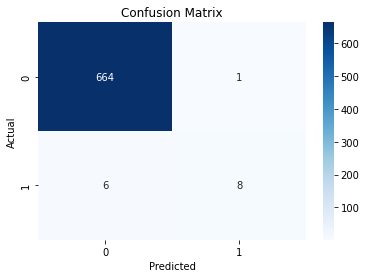

In [22]:
cm = confusion_matrix(y_test, y_pred)


sn.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:
rows_with_1 = df[df['BinaryLeagueIndex'] == 1]
rows_with_1

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,...,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,Total_Perceptions_per_APM,non_unique,long_game,BinaryLeagueIndex
7,6,17.000000,42.000000,10000.000000,212.6022,0.009040,0.000676,6,0.001164,0.001253,...,6.6104,45,0.002277,9,0.000129,0.000249,0.000023,206.6022,0.052359,1
104,6,21.000000,24.000000,1000.000000,286.4538,0.017852,0.000717,6,0.000049,0.001298,...,5.7171,30,0.001372,6,0.000000,0.000000,0.000022,280.4538,0.001484,1
119,6,24.000000,16.000000,1250.000000,216.6852,0.011957,0.000396,6,0.000528,0.000839,...,5.0083,33,0.000688,8,0.000038,0.000000,0.000026,210.6852,0.017413,1
320,6,25.000000,42.000000,2400.000000,182.6208,0.005607,0.000310,8,0.000203,0.000662,...,5.4065,18,0.001164,7,0.000000,0.000000,0.000029,174.6208,0.003652,1
368,6,19.000000,56.000000,1700.000000,130.8600,0.003419,0.000552,5,0.000104,0.000069,...,6.6667,15,0.000932,5,0.000000,0.000000,0.000024,125.8600,0.001554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,7,21.718638,26.690888,6491.960546,259.6296,0.020425,0.000743,9,0.000621,0.000146,...,6.2754,46,0.000877,5,0.000000,0.000000,0.000018,250.6296,0.028574,1
3391,7,19.490935,28.108215,7998.069219,314.6700,0.028043,0.001157,10,0.000246,0.001083,...,7.1965,16,0.000788,4,0.000000,0.000000,0.000014,304.6700,0.003939,1
3392,7,19.735045,28.292566,8036.699102,299.4282,0.028341,0.000860,7,0.000338,0.000169,...,6.3979,19,0.001260,4,0.000000,0.000000,0.000015,292.4282,0.006421,1
3393,7,18.232043,33.128584,10252.639932,375.8664,0.036436,0.000594,5,0.000204,0.000780,...,7.9615,15,0.000613,6,0.000000,0.000631,0.000012,370.8664,0.003064,1


In [24]:
model_results = {
    'Model Type' : ['GBDT', 'Neural Network Linear Regression', 'KNN', 'Binary Logistic Regression'],
    ' ': [a,b,c,d]

}

mod = pd.DataFrame(model_results)


,Model Type,
0,GBDT,"(Accuracy:, 0.39911634756995584)"
1,Neural Network Linear Regression,"(Accuracy:, 0.39911634756995584)"
2,KNN,"(Accuracy:, 0.36524300441826213)"
3,Binary Logistic Regression,"(Accuracy:, 0.9896907216494846)"


## Findings

In creating my models, I was able to correctly estimate the LeagueIndex forty percent of the time.

When I attempted to estimate if the player was in professional, or in LeagueIndex one or two, I was able to estimate this correctly 99 percent of the time.

With there being only eight different options the models were able to narrow the choices to two or three different ranks for the information given and this led to a prediction success rate of around 40 percent.

The best model was the gradient boosted decision trees but the neural network linear regression model only performed slightly worse.


In [25]:
mod

,Model Type,
0,GBDT,"(Accuracy:, 0.39911634756995584)"
1,Neural Network Linear Regression,"(Accuracy:, 0.39911634756995584)"
2,KNN,"(Accuracy:, 0.36524300441826213)"
3,Binary Logistic Regression,"(Accuracy:, 0.9896907216494846)"


## Additonal Information

If I was given the opportunity to collect data I believe the best way would be to modify the data collection process. While the data is collected on a game by game basis I believe it would be useful to study it on the player by player level in each game. I would use this data to then create certain matchup characteristics for certain races and see how those races compare when competing against different races.